# Computer Vision HT 2025 - Practical 2 (v1.0)

## Instructions

1. Start Google Colab: https://colab.research.google.com. A modal dialog should have appeared to open a new notebook. If not, go to "File>Open notebook".
2. From the open notebook dialog, select the GitHub "tab" and enter this URL: https://github.com/chrirupp/cv_course
3. The notebook(s) should appear (*.ipynb). Select the one for the current practical.
4. To run a notebook on Colab you will typically need some data files (e.g., images). As Colab only loads the notebook itself, these other files need to be downloaded separately. The following cell is a `%%sh` block that downloads the required files. You can inspect the downloaded files by clicking on the "Files" tab on the left.

## Practicalities

The signing-off happens in the last half hour of each session or at the beginning of the following one.
As usual, when checking your work the demonstrator will want to see a working version of the program in action, as well as appropriate comments of your code. Try to make your report as concise as possible, perhaps in the form of appropriate comments to your code.

Since this is a new practical task, any errors, ambiguities or suggestions for improvement should be flagged as soon as possible.

If you are not familiar with the way practicals run, there are department-wide [rules](https://www.cs.ox.ac.uk/teaching/courses/2023-2024/practicals/). There you will find how the compulsory part, the optional tasks, and your report will factor into your mark.

## Advice

* You will need to look at the code for the lectures. There you will find many related computations that you can reuse and adapt to solve the practicals.
* The compulsory part of this practical is designed to give you additional understanding of the concepts taught in the lectures. It should be achievable in one session.

Here we import some libraries that we will need to process images, do maths, and to visualise results.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
from tqdm import tqdm
from torchvision import datasets, transforms
%matplotlib inline

The usual set of helper functions:

In [2]:
%%sh
# Download the data - you need to do this only once
wget --no-verbose --output-document=image_dog.jpg https://github.com/chrirupp/cv_course/raw/main/data/image_dog.jpg

2025-02-13 13:20:02 URL:https://raw.githubusercontent.com/chrirupp/cv_course/main/data/image_dog.jpg [138693/138693] -> "image_dog.jpg" [1]


In [3]:
class Visualizer():
    def __init__(self, num_rows=1, num_cols=1, figsize=(5,5), axis_off=True, title='', tight=False, cm=None):
        fig, self.axs = plt.subplots(num_rows, num_cols, figsize=figsize, squeeze=False)
        # remove ticks
        if axis_off:
          plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
        # set colormap
        if cm is not None:
            plt.set_cmap(cm)
        # set supertitle
        fig.suptitle(title)
        if tight:
            fig.subplots_adjust(top=0.88)

    def add_image_subplot(self, i, j, image, normalize=False, title_str=''):
        if normalize:
            image = self.normalize_image(image)
        if len(image.shape) == 3:
            #BGR -> RGB
            image = image[:, :, ::-1]
        self.axs[i, j].imshow(image)
        self.axs[i, j].set_title(title_str)

    def add_stem_subplot(self, i, j, x, y, title_str=''):
        self.axs[i, j].stem(x, y)
        self.axs[i, j].set_title(title_str)

    def add_subplot(self, i, j, data, title_str=''):
        self.axs[i, j].plot(data)
        self.axs[i, j].set_title(title_str)

    def add_bar_subplot(self, i, j, x, y, title_str=''):
        self.axs[i, j].bar(x, y)
        self.axs[i, j].set_title(title_str)

    @staticmethod
    def normalize_image(image):
        img = np.float64(image) - np.min(image)
        img /= np.max(img)
        return img

## Problem 2.1 - Image Classification

Let us train a linear classifier on the CIFAR10 dataset.
First, we will load the dataset and show some sample images. The convention in pytorch is to store images in a tensor of shape $C\times H \times W$, where $C=3$ is the number of channels and $H$ and $W$ are the height and width of the image. For training, we typically load mini-batches of size $N$, which adds another dimension $N \times C \times H \times W$ to our data. The image visualiser expects data in the format $H \times W \times C$ so you will find some shuffling of dimension in the code below. Additionally, OpenCV prefers processing images in BGR format, while pytorch uses RGB so we also need to reverse the order of the $C$ dimension.

100%|██████████| 170M/170M [00:01<00:00, 105MB/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


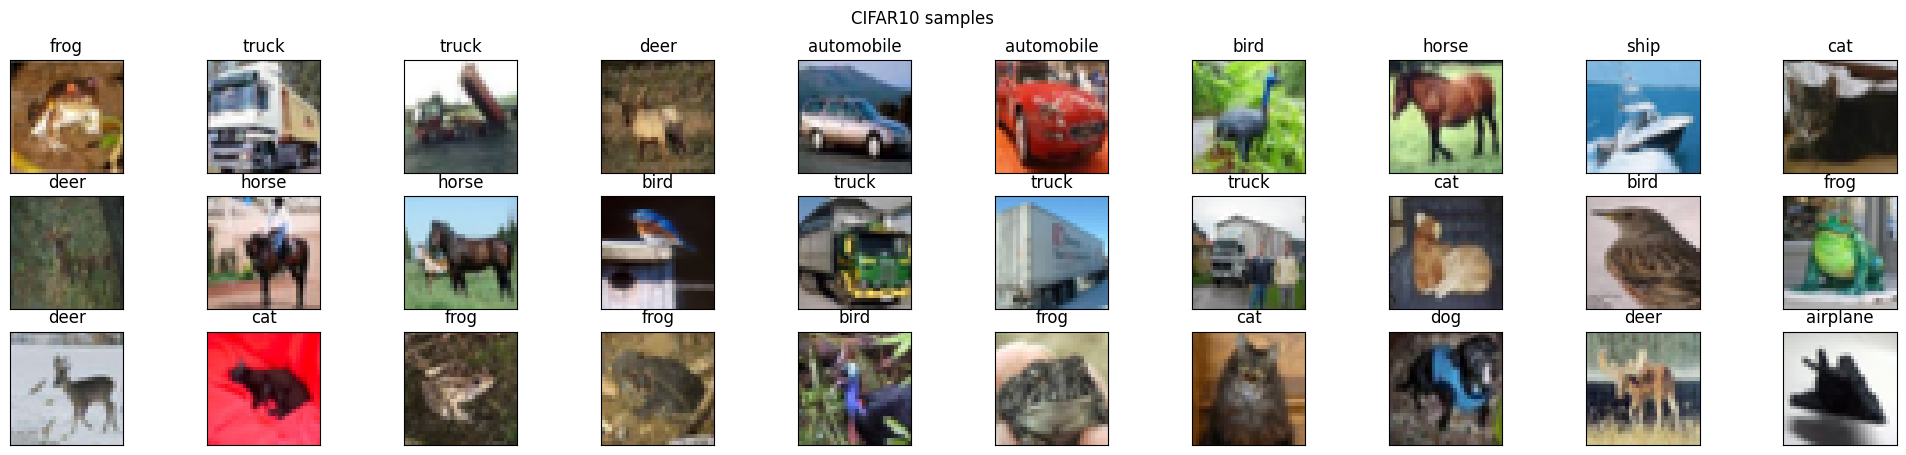

In [4]:
# get cifar10 dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10('../data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10('../data', train=False, download=True, transform=transform)


# samples from cifar10 dataset
vis = Visualizer(3, 10, figsize=(25,5), title='CIFAR10 samples')
for i in range(30):
    image = train_dataset[i][0].permute(1, 2, 0).numpy()[:,:,::-1]
    vis.add_image_subplot(i // 10, i % 10, image, title_str=train_dataset.classes[train_dataset[i][1]])


While we can "train" a linear classifier by solving a linear system analytically, we will now do it with gradient descent to familiarise ourselves with the concepts of training. Training typically happens in epochs, where one epoch is a full loop over the training set. Familiarise yourself with the training code below. Answer the following questions:

* What is the purpose of `optimizer.zero_grad()`?
Reset the gradients to zero so as not to accumulate gradients of different iterations.
* What is `citerion`?
The loss-function, often cross-entropy for classification
* How do we determine which class the model predicts?
We use argmax on the logits
* How many parameters does our model have?
3x32x32x10
* What accuracy would we expect for a model that is randomly initialised?
1/nb_classes

In [5]:
# create dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

def evaluate(model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = 100. * correct / len(test_loader.dataset)
    return accuracy

def train(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    test_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        for data, target in tqdm(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        test_acc = evaluate(model, test_loader)
        test_accuracies.append(test_acc)
        print(f'Epoch {epoch+1}/{num_epochs}, Test accuracy: {test_acc:.2f}%')

    return train_losses, test_accuracies

class LinearModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = torch.nn.Linear(3*32*32, 10)

    def forward(self, x):
        x = x.view(-1, 3*32*32)
        x = self.fc(x)
        return x

model = LinearModel()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_losses, test_accuracies = train(model, train_loader, test_loader, criterion, optimizer, num_epochs=5)


100%|██████████| 391/391 [00:09<00:00, 42.94it/s]


Epoch 1/5, Test accuracy: 36.19%


100%|██████████| 391/391 [00:09<00:00, 42.08it/s]


Epoch 2/5, Test accuracy: 37.42%


100%|██████████| 391/391 [00:09<00:00, 42.55it/s]


Epoch 3/5, Test accuracy: 36.80%


100%|██████████| 391/391 [00:09<00:00, 42.70it/s]


Epoch 4/5, Test accuracy: 37.20%


100%|██████████| 391/391 [00:08<00:00, 45.04it/s]


Epoch 5/5, Test accuracy: 34.55%


Now that the model is trained, visualise the weights of the linear layer. There are $3\cdot 32 \cdot 32$ weights for each class which you can visualise simply as an image. What do you see? Why does it look like that?

In [20]:
weights_tensor=model.fc.weight.detach().view(10,32,32,3).numpy()

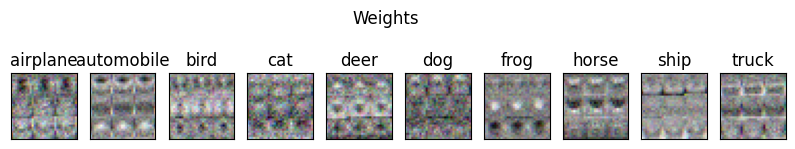

In [21]:
vis = Visualizer(1, 10, figsize=(10,2), title='Weights')
for i in range(10):
    weights = weights_tensor[i]
    # TODO: visualise weights
    vis.add_image_subplot(0, i, weights, title_str=train_dataset.classes[i], normalize=True)

We see some noisy shapes which look like different kind of blobs. These respective patterns most certainly have higher response to the corresponding classes

We will now train a small CNN. It consists of
* Convolution: size 3x3, number of channels 3 (RGB), number of filters: 16, padding: 1 on all sides
* ReLU
* MaxPooling: size 2x2, stride: 2
* Fully Connected layer: 4096 x 10

In [24]:
class MiniCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.fc = torch.nn.Linear(4096, 10)

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 4096)
        x = self.fc(x)
        return x

model = MiniCNN()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
train_losses,test_accuracies=train(model,train_loader,test_loader,criterion,optimizer)

100%|██████████| 391/391 [00:24<00:00, 15.87it/s]


Epoch 1/10, Test accuracy: 46.06%


100%|██████████| 391/391 [00:25<00:00, 15.14it/s]


Epoch 2/10, Test accuracy: 53.14%


100%|██████████| 391/391 [00:27<00:00, 14.24it/s]


Epoch 3/10, Test accuracy: 56.10%


100%|██████████| 391/391 [00:25<00:00, 15.63it/s]


Epoch 4/10, Test accuracy: 57.31%


100%|██████████| 391/391 [00:26<00:00, 14.54it/s]


Epoch 5/10, Test accuracy: 57.84%


100%|██████████| 391/391 [00:25<00:00, 15.21it/s]


Epoch 6/10, Test accuracy: 59.39%


100%|██████████| 391/391 [00:24<00:00, 16.27it/s]


Epoch 7/10, Test accuracy: 58.83%


100%|██████████| 391/391 [00:25<00:00, 15.60it/s]


Epoch 8/10, Test accuracy: 60.27%


100%|██████████| 391/391 [00:24<00:00, 16.08it/s]


Epoch 9/10, Test accuracy: 60.84%


100%|██████████| 391/391 [00:30<00:00, 12.66it/s]


Epoch 10/10, Test accuracy: 61.41%


This model should achieve around 57% accuracy on the test set (with the default settings for batch size, learning rate, and number of epochs).

Answer the following questions:
* Why do we need to define the convolution and FC layer in the constructor (`__init__()`) of the model, but ReLU and max_pool are simply used in the forward pass? ReLU and max_pool are not parametric so they don't need to be in the constructor
* How do we know that the fully connected layer needs to be of size 4096 x 10?
3x32x32 initially. The convolutional layer keeps the same dimensions (1 stride and padding) : 16x32x32. The MaxPool divides the image dimension by 4 : 32x8x16=4096.

Then, expand the model with a second set of convolution (3x3, 32 filters, padding 1), ReLU, max_pool (2x2, stride 2). You will need to also adjust the size of the FC layer accordingly. Confirm that this improves the accuracy.

In [27]:
class MiniCNN2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=torch.nn.Conv2d(3,16,kernel_size=3,stride=1,padding=1)
        self.conv2=torch.nn.Conv2d(16,32,kernel_size=3,stride=1,padding=1)
        self.activation=torch.nn.ReLU()
        self.maxpool=torch.nn.MaxPool2d(kernel_size=2,stride=2)
        self.fc=torch.nn.Linear(32*8*8,10)

    def forward(self, x):
        x=self.conv1(x)
        x=self.activation(x)
        x=self.maxpool(x)
        x=self.conv2(x)
        x=self.activation(x)
        x=self.maxpool(x)
        x=x.view(-1,32*8*8)
        x=self.fc(x)
        return x

model = MiniCNN2()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
train_losses,test_accuracies=train(model,train_loader,test_loader,criterion,optimizer)

100%|██████████| 391/391 [00:38<00:00, 10.26it/s]


Epoch 1/10, Test accuracy: 50.69%


100%|██████████| 391/391 [00:38<00:00, 10.15it/s]


Epoch 2/10, Test accuracy: 54.71%


100%|██████████| 391/391 [00:39<00:00,  9.88it/s]


Epoch 3/10, Test accuracy: 57.59%


100%|██████████| 391/391 [00:40<00:00,  9.75it/s]


Epoch 4/10, Test accuracy: 59.05%


100%|██████████| 391/391 [00:38<00:00, 10.17it/s]


Epoch 5/10, Test accuracy: 61.22%


100%|██████████| 391/391 [00:38<00:00, 10.25it/s]


Epoch 6/10, Test accuracy: 63.02%


100%|██████████| 391/391 [00:38<00:00, 10.20it/s]


Epoch 7/10, Test accuracy: 63.50%


100%|██████████| 391/391 [00:38<00:00, 10.18it/s]


Epoch 8/10, Test accuracy: 64.32%


100%|██████████| 391/391 [00:38<00:00, 10.26it/s]


Epoch 9/10, Test accuracy: 65.31%


100%|██████████| 391/391 [00:40<00:00,  9.68it/s]


Epoch 10/10, Test accuracy: 64.17%


### Optional Task - Be a hero
You have now several options that might improve the performance:
* Change the architecture further.
* Train longer.
* Change other hyper parameters: batch size, learning rate, kernel sizes, number of filters, activation functions, etc.
* Data augmentations such as left-right flipping (see `transform` in the beginning).

Try to find a combination that gets better accuracy than `MiniCNN2` (at least 63%). Do not change the test set! (State-of-the-art models get around 95% ;) )
Hint: if you are considering to tinker with this for a while: switch to hardware acceleration (GPU) - Edit->Notebook settings. Then change the code to move the model and tensors to the GPU `.to("cuda")` before starting to train. You will need to move each batch to the device too. Move predictions back to the CPU `.cpu()` so that they do not accumulate memory.

## Problem 2.2 - Occlusion Method

The code for the lecture implements the occlusion method for CNNs, by blocking out (i.e. setting to 0) parts of the image and measuring the change in response for the target class for every location, and converting it into a heatmap.
We will now do the same for a transformer architecture. However, since the transformer already divides the image into patches, we can directly block out tokens instead of modifying the image.

Using cache found in /root/.cache/torch/hub/pytorch_vision_main


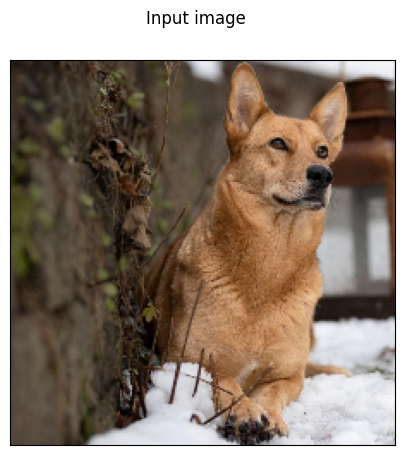

In [45]:
model = torch.hub.load('pytorch/vision', 'vit_b_16', weights=torchvision.models.ViT_B_16_Weights.IMAGENET1K_V1)
class_names = torchvision.models.ViT_B_16_Weights.IMAGENET1K_V1.meta["categories"]

# load image
image = cv2.imread('image_dog.jpg')

# preprocess image
image = image[:, :image.shape[0]]
image = cv2.resize(image, (224, 224))
vis = Visualizer(num_rows=1, num_cols=1, figsize=(5,5), axis_off=True, title='Input image')
vis.add_image_subplot(0, 0, image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image / 255.0
image = image - np.array([0.485, 0.456, 0.406])
image = image / np.array([0.229, 0.224, 0.225])
image = image.transpose(2, 0, 1)
image = np.expand_dims(image, axis=0)
image = torch.from_numpy(image).float()

Models trained on the ImageNet dataset are trained using normalised images (subtract mean, divide by variance) this is reflected in the image pre-processing code above.

Below you are given a function `predict`.

Explain:
* the role of `batch_class_token`

It duplicates the class_token to represent the whole class and attend to the different patches.

* `encoder.pos_embedding`

Positional embeddings of the patches to have the positional information.

* the reason for `x[:, 0]`

We select the class token for downstream classification

In [46]:
def predict(model, image):
    x = model._process_input(image)
    n = x.shape[0]
    batch_class_token = model.class_token.expand(n, -1, -1)
    x = torch.cat([batch_class_token, x], dim=1)

    input = x + model.encoder.pos_embedding
    input = model.encoder.layers(input)
    x = model.encoder.ln(input)
    x = x[:, 0]
    return model.heads(x).detach().cpu().numpy()

# predict
output = predict(model, image)
pred = class_names[output.argmax()]
print(f'Predicted class: {pred}')

Predicted class: dingo


Implement the occlusion method by individually "occluding" image token from the input to the encoder and measuring the change in the target class. Be careful: the class-token is the first token in the input sequence. Visualise the heatmap.

Class: dingo


  1%|          | 1/196 [00:00<02:30,  1.30it/s]

0.93841213


  1%|          | 2/196 [00:01<02:26,  1.33it/s]

0.9493679


  2%|▏         | 3/196 [00:02<02:25,  1.32it/s]

1.0230342


  2%|▏         | 4/196 [00:03<02:24,  1.33it/s]

1.0151532


  3%|▎         | 5/196 [00:03<02:23,  1.33it/s]

1.0193473


  3%|▎         | 6/196 [00:04<02:21,  1.34it/s]

0.8176903


  4%|▎         | 7/196 [00:05<02:21,  1.34it/s]

0.8270387


  4%|▍         | 8/196 [00:05<02:20,  1.34it/s]

1.1620111


  5%|▍         | 9/196 [00:06<02:19,  1.34it/s]

2.130259


  5%|▌         | 10/196 [00:07<02:18,  1.34it/s]

1.2636197


  6%|▌         | 11/196 [00:08<02:37,  1.17it/s]

0.94050467


  6%|▌         | 12/196 [00:09<02:55,  1.05it/s]

0.8149737


  7%|▋         | 13/196 [00:10<02:57,  1.03it/s]

0.84750926


  7%|▋         | 14/196 [00:11<02:44,  1.11it/s]

0.98253816


  8%|▊         | 15/196 [00:12<02:34,  1.17it/s]

1.1108142


  8%|▊         | 16/196 [00:13<02:28,  1.21it/s]

0.9738226


  9%|▊         | 17/196 [00:13<02:22,  1.26it/s]

1.4030858


  9%|▉         | 18/196 [00:14<02:19,  1.28it/s]

1.0341372


 10%|▉         | 19/196 [00:15<02:16,  1.30it/s]

1.063022


 10%|█         | 20/196 [00:15<02:14,  1.31it/s]

1.1821378


 11%|█         | 21/196 [00:16<02:12,  1.32it/s]

1.0026885


 11%|█         | 22/196 [00:17<02:11,  1.32it/s]

0.8718395


 12%|█▏        | 23/196 [00:18<02:30,  1.15it/s]

3.2007186


 12%|█▏        | 24/196 [00:19<02:43,  1.05it/s]

2.4758906


 13%|█▎        | 25/196 [00:20<02:32,  1.12it/s]

1.5072905


 13%|█▎        | 26/196 [00:21<02:45,  1.02it/s]

2.0227072


 14%|█▍        | 27/196 [00:22<02:54,  1.04s/it]

1.0792168


 14%|█▍        | 28/196 [00:23<02:48,  1.00s/it]

1.4574054


 15%|█▍        | 29/196 [00:24<02:34,  1.08it/s]

0.8763372


 15%|█▌        | 30/196 [00:25<02:24,  1.15it/s]

0.9299004


 16%|█▌        | 31/196 [00:26<02:18,  1.19it/s]

1.0698241


 16%|█▋        | 32/196 [00:26<02:13,  1.23it/s]

1.1329999


 17%|█▋        | 33/196 [00:27<02:10,  1.25it/s]

0.9249577


 17%|█▋        | 34/196 [00:28<02:06,  1.28it/s]

1.2089388


 18%|█▊        | 35/196 [00:29<02:04,  1.30it/s]

0.90304


 18%|█▊        | 36/196 [00:29<02:02,  1.30it/s]

1.1204586


 19%|█▉        | 37/196 [00:30<02:01,  1.31it/s]

2.7869384


 19%|█▉        | 38/196 [00:31<01:59,  1.32it/s]

3.2090836


 20%|█▉        | 39/196 [00:32<01:58,  1.33it/s]

3.7571504


 20%|██        | 40/196 [00:32<01:57,  1.33it/s]

1.9737154


 21%|██        | 41/196 [00:33<01:59,  1.29it/s]

1.2700992


 21%|██▏       | 42/196 [00:34<02:17,  1.12it/s]

1.097653


 22%|██▏       | 43/196 [00:35<02:29,  1.02it/s]

0.9545727


 22%|██▏       | 44/196 [00:36<02:21,  1.07it/s]

0.96285045


 23%|██▎       | 45/196 [00:37<02:12,  1.14it/s]

0.862387


 23%|██▎       | 46/196 [00:38<02:05,  1.19it/s]

0.99133617


 24%|██▍       | 47/196 [00:39<02:00,  1.23it/s]

1.1138566


 24%|██▍       | 48/196 [00:39<01:56,  1.27it/s]

1.0055486


 25%|██▌       | 49/196 [00:40<01:54,  1.28it/s]

1.0709169


 26%|██▌       | 50/196 [00:41<01:53,  1.29it/s]

1.4494585


 26%|██▌       | 51/196 [00:42<01:50,  1.31it/s]

1.8732082


 27%|██▋       | 52/196 [00:42<01:49,  1.32it/s]

3.0996053


 27%|██▋       | 53/196 [00:43<01:48,  1.32it/s]

2.5865688


 28%|██▊       | 54/196 [00:44<01:46,  1.33it/s]

3.158044


 28%|██▊       | 55/196 [00:45<01:45,  1.34it/s]

0.8450637


 29%|██▊       | 56/196 [00:45<01:45,  1.33it/s]

1.0466664


 29%|██▉       | 57/196 [00:46<01:49,  1.26it/s]

1.0096412


 30%|██▉       | 58/196 [00:47<02:05,  1.10it/s]

0.9653244


 30%|███       | 59/196 [00:48<02:14,  1.02it/s]

0.9111398


 31%|███       | 60/196 [00:49<02:05,  1.08it/s]

0.9614019


 31%|███       | 61/196 [00:50<01:57,  1.15it/s]

1.0052164


 32%|███▏      | 62/196 [00:51<01:51,  1.20it/s]

0.9867959


 32%|███▏      | 63/196 [00:52<01:48,  1.23it/s]

0.8555229


 33%|███▎      | 64/196 [00:52<01:44,  1.26it/s]

1.6234547


 33%|███▎      | 65/196 [00:53<01:42,  1.28it/s]

3.2317789


 34%|███▎      | 66/196 [00:54<01:39,  1.30it/s]

2.6471543


 34%|███▍      | 67/196 [00:55<01:39,  1.30it/s]

2.9916668


 35%|███▍      | 68/196 [00:55<01:37,  1.31it/s]

5.4085956


 35%|███▌      | 69/196 [00:56<01:36,  1.32it/s]

1.0607501


 36%|███▌      | 70/196 [00:57<01:35,  1.32it/s]

1.3488163


 36%|███▌      | 71/196 [00:58<01:34,  1.32it/s]

1.0166068


 37%|███▋      | 72/196 [00:58<01:33,  1.33it/s]

0.87578887


 37%|███▋      | 73/196 [01:00<02:06,  1.03s/it]

0.84925425


 38%|███▊      | 74/196 [01:01<02:10,  1.07s/it]

1.0115621


 38%|███▊      | 75/196 [01:02<02:02,  1.01s/it]

0.95928663


 39%|███▉      | 76/196 [01:03<01:52,  1.07it/s]

0.91311437


 39%|███▉      | 77/196 [01:04<01:44,  1.14it/s]

2.0799248


 40%|███▉      | 78/196 [01:04<01:38,  1.20it/s]

1.5659233


 40%|████      | 79/196 [01:05<01:34,  1.24it/s]

1.1471571


 41%|████      | 80/196 [01:06<01:32,  1.26it/s]

2.2145035


 41%|████▏     | 81/196 [01:06<01:29,  1.29it/s]

2.7150762


 42%|████▏     | 82/196 [01:07<01:27,  1.30it/s]

1.0499963


 42%|████▏     | 83/196 [01:08<01:26,  1.31it/s]

1.1095608


 43%|████▎     | 84/196 [01:09<01:25,  1.32it/s]

1.4318538


 43%|████▎     | 85/196 [01:09<01:23,  1.32it/s]

1.0123374


 44%|████▍     | 86/196 [01:10<01:23,  1.32it/s]

1.1882026


 44%|████▍     | 87/196 [01:11<01:22,  1.33it/s]

0.7892581


 45%|████▍     | 88/196 [01:12<01:25,  1.26it/s]

0.9068562


 45%|████▌     | 89/196 [01:13<01:38,  1.09it/s]

0.84725183


 46%|████▌     | 90/196 [01:14<01:44,  1.01it/s]

0.9325212


 46%|████▋     | 91/196 [01:15<01:37,  1.07it/s]

1.3144825


 47%|████▋     | 92/196 [01:16<01:30,  1.15it/s]

2.1765366


 47%|████▋     | 93/196 [01:17<01:26,  1.20it/s]

1.1628506


 48%|████▊     | 94/196 [01:17<01:22,  1.23it/s]

1.1475706


 48%|████▊     | 95/196 [01:18<01:19,  1.27it/s]

1.5291305


 49%|████▉     | 96/196 [01:19<01:17,  1.29it/s]

1.3678408


 49%|████▉     | 97/196 [01:20<01:16,  1.30it/s]

1.1441077


 50%|█████     | 98/196 [01:20<01:14,  1.31it/s]

1.1613605


 51%|█████     | 99/196 [01:21<01:19,  1.21it/s]

0.9374675


 51%|█████     | 100/196 [01:22<01:27,  1.10it/s]

1.0225976


 52%|█████▏    | 101/196 [01:23<01:26,  1.10it/s]

0.91383666


 52%|█████▏    | 102/196 [01:25<01:52,  1.20s/it]

0.95248514


 53%|█████▎    | 103/196 [01:26<01:52,  1.21s/it]

1.0189276


 53%|█████▎    | 104/196 [01:27<01:47,  1.17s/it]

1.7060986


 54%|█████▎    | 105/196 [01:28<01:34,  1.04s/it]

2.0653362


 54%|█████▍    | 106/196 [01:29<01:26,  1.04it/s]

1.8505318


 55%|█████▍    | 107/196 [01:30<01:19,  1.11it/s]

1.0941724


 55%|█████▌    | 108/196 [01:30<01:15,  1.17it/s]

1.0989116


 56%|█████▌    | 109/196 [01:31<01:11,  1.21it/s]

1.6213948


 56%|█████▌    | 110/196 [01:32<01:09,  1.24it/s]

2.4138436


 57%|█████▋    | 111/196 [01:33<01:07,  1.26it/s]

1.2866162


 57%|█████▋    | 112/196 [01:33<01:05,  1.29it/s]

1.259538


 58%|█████▊    | 113/196 [01:34<01:03,  1.30it/s]

0.742114


 58%|█████▊    | 114/196 [01:35<01:02,  1.31it/s]

0.95589834


 59%|█████▊    | 115/196 [01:36<01:01,  1.32it/s]

0.9389409


 59%|█████▉    | 116/196 [01:36<01:00,  1.33it/s]

0.8941913


 60%|█████▉    | 117/196 [01:37<00:59,  1.33it/s]

1.3253003


 60%|██████    | 118/196 [01:38<01:06,  1.17it/s]

1.2191689


 61%|██████    | 119/196 [01:39<01:13,  1.05it/s]

1.2732606


 61%|██████    | 120/196 [01:40<01:13,  1.04it/s]

2.5817418


 62%|██████▏   | 121/196 [01:41<01:07,  1.11it/s]

1.2519934


 62%|██████▏   | 122/196 [01:42<01:03,  1.17it/s]

1.8853931


 63%|██████▎   | 123/196 [01:43<00:59,  1.22it/s]

2.6701975


 63%|██████▎   | 124/196 [01:43<00:57,  1.25it/s]

1.1640015


 64%|██████▍   | 125/196 [01:44<00:55,  1.28it/s]

0.92399824


 64%|██████▍   | 126/196 [01:45<00:53,  1.30it/s]

1.0565587


 65%|██████▍   | 127/196 [01:46<00:52,  1.31it/s]

0.91264135


 65%|██████▌   | 128/196 [01:46<00:51,  1.32it/s]

0.9425521


 66%|██████▌   | 129/196 [01:47<00:50,  1.33it/s]

0.96115154


 66%|██████▋   | 130/196 [01:48<00:49,  1.34it/s]

0.7870254


 67%|██████▋   | 131/196 [01:49<00:48,  1.34it/s]

1.3043627


 67%|██████▋   | 132/196 [01:49<00:47,  1.33it/s]

1.1231825


 68%|██████▊   | 133/196 [01:50<00:47,  1.34it/s]

1.8083601


 68%|██████▊   | 134/196 [01:51<00:54,  1.14it/s]

1.3244913


 69%|██████▉   | 135/196 [01:52<00:58,  1.04it/s]

1.1509489


 69%|██████▉   | 136/196 [01:53<00:57,  1.04it/s]

1.773859


 70%|██████▉   | 137/196 [01:54<00:52,  1.11it/s]

0.85135037


 70%|███████   | 138/196 [01:55<00:49,  1.17it/s]

0.98570776


 71%|███████   | 139/196 [01:56<00:48,  1.18it/s]

1.3958534


 71%|███████▏  | 140/196 [01:57<00:55,  1.01it/s]

1.1206299


 72%|███████▏  | 141/196 [01:58<00:50,  1.09it/s]

1.385428


 72%|███████▏  | 142/196 [01:59<00:46,  1.16it/s]

0.7966299


 73%|███████▎  | 143/196 [01:59<00:43,  1.21it/s]

0.88793343


 73%|███████▎  | 144/196 [02:00<00:41,  1.24it/s]

0.858411


 74%|███████▍  | 145/196 [02:01<00:40,  1.26it/s]

1.0263684


 74%|███████▍  | 146/196 [02:02<00:38,  1.29it/s]

0.91428804


 75%|███████▌  | 147/196 [02:02<00:37,  1.30it/s]

2.020057


 76%|███████▌  | 148/196 [02:03<00:36,  1.31it/s]

1.8819737


 76%|███████▌  | 149/196 [02:04<00:41,  1.13it/s]

1.1238316


 77%|███████▋  | 150/196 [02:05<00:44,  1.03it/s]

1.3618172


 77%|███████▋  | 151/196 [02:06<00:42,  1.05it/s]

0.8287272


 78%|███████▊  | 152/196 [02:07<00:39,  1.12it/s]

0.9418578


 78%|███████▊  | 153/196 [02:08<00:36,  1.18it/s]

1.17822


 79%|███████▊  | 154/196 [02:09<00:34,  1.23it/s]

1.0237458


 79%|███████▉  | 155/196 [02:09<00:32,  1.26it/s]

1.3492624


 80%|███████▉  | 156/196 [02:10<00:31,  1.27it/s]

0.996189


 80%|████████  | 157/196 [02:11<00:30,  1.30it/s]

0.9415971


 81%|████████  | 158/196 [02:12<00:29,  1.31it/s]

0.86479604


 81%|████████  | 159/196 [02:12<00:28,  1.32it/s]

0.99689054


 82%|████████▏ | 160/196 [02:13<00:27,  1.33it/s]

1.10643


 82%|████████▏ | 161/196 [02:14<00:26,  1.33it/s]

1.6648917


 83%|████████▎ | 162/196 [02:15<00:25,  1.33it/s]

1.4422466


 83%|████████▎ | 163/196 [02:15<00:24,  1.33it/s]

1.3918747


 84%|████████▎ | 164/196 [02:16<00:24,  1.30it/s]

1.5337086


 84%|████████▍ | 165/196 [02:17<00:27,  1.11it/s]

1.273372


 85%|████████▍ | 166/196 [02:18<00:29,  1.02it/s]

1.7446468


 85%|████████▌ | 167/196 [02:19<00:26,  1.08it/s]

0.96728456


 86%|████████▌ | 168/196 [02:20<00:24,  1.14it/s]

1.3630497


 86%|████████▌ | 169/196 [02:21<00:22,  1.19it/s]

0.9585097


 87%|████████▋ | 170/196 [02:22<00:21,  1.22it/s]

0.9825439


 87%|████████▋ | 171/196 [02:22<00:19,  1.26it/s]

0.85537905


 88%|████████▊ | 172/196 [02:23<00:18,  1.28it/s]

0.93342274


 88%|████████▊ | 173/196 [02:24<00:17,  1.30it/s]

0.9003186


 89%|████████▉ | 174/196 [02:25<00:16,  1.31it/s]

1.0175728


 89%|████████▉ | 175/196 [02:25<00:15,  1.32it/s]

1.2749344


 90%|████████▉ | 176/196 [02:26<00:15,  1.33it/s]

1.3233202


 90%|█████████ | 177/196 [02:27<00:14,  1.33it/s]

1.2152451


 91%|█████████ | 178/196 [02:28<00:13,  1.33it/s]

2.4391334


 91%|█████████▏| 179/196 [02:28<00:12,  1.34it/s]

1.2278728


 92%|█████████▏| 180/196 [02:29<00:12,  1.26it/s]

1.2207612


 92%|█████████▏| 181/196 [02:30<00:13,  1.10it/s]

0.9272932


 93%|█████████▎| 182/196 [02:32<00:13,  1.02it/s]

1.2843957


 93%|█████████▎| 183/196 [02:32<00:11,  1.09it/s]

0.9207447


 94%|█████████▍| 184/196 [02:33<00:10,  1.15it/s]

1.0893974


 94%|█████████▍| 185/196 [02:34<00:09,  1.13it/s]

1.1984785


 95%|█████████▍| 186/196 [02:35<00:09,  1.03it/s]

1.1025003


 95%|█████████▌| 187/196 [02:36<00:09,  1.02s/it]

0.97344375


 96%|█████████▌| 188/196 [02:37<00:07,  1.05it/s]

1.3662908


 96%|█████████▋| 189/196 [02:38<00:06,  1.12it/s]

0.9481201


 97%|█████████▋| 190/196 [02:39<00:05,  1.18it/s]

1.0683476


 97%|█████████▋| 191/196 [02:39<00:04,  1.22it/s]

1.5910516


 98%|█████████▊| 192/196 [02:40<00:03,  1.25it/s]

2.228246


 98%|█████████▊| 193/196 [02:41<00:02,  1.27it/s]

1.288508


 99%|█████████▉| 194/196 [02:42<00:01,  1.29it/s]

1.2911093


 99%|█████████▉| 195/196 [02:43<00:00,  1.12it/s]

1.0392586


100%|██████████| 196/196 [02:44<00:00,  1.19it/s]

1.1988294


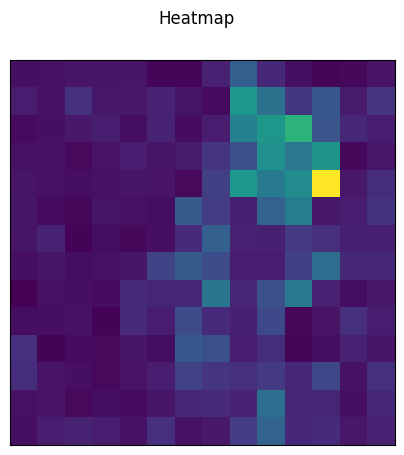

In [47]:
def predict_drop_token(model, image, token):
    x = model._process_input(image)
    n = x.shape[0]
    batch_class_token = model.class_token.expand(n, -1, -1)
    x = torch.cat([batch_class_token, x], dim=1)
    input = x + model.encoder.pos_embedding
    #occlusion
    input[:,1+token,:]=torch.zeros(input.shape[0],1,input.shape[2])
    input = model.encoder.layers(input)
    x = model.encoder.ln(input)
    x = x[:, 0]
    return model.heads(x).detach().cpu().numpy()

# get prediction
with torch.no_grad():
    original_prediction = predict(model,image) # TODO: get the original prediction
    #print(original_prediction)

top_class = original_prediction.argmax()
print(f'Class: {class_names[top_class]}')

heatmap = np.zeros((14, 14))
for i in tqdm(range(heatmap.size)):
    response = predict_drop_token(model, image, i)
    heatmap[i//14, i%14] = np.linalg.norm((response-original_prediction))  # TODO: calculate the heatmap
    print(np.linalg.norm((response-original_prediction)))

# plot heatmap
vis = Visualizer(num_rows=1, num_cols=1, figsize=(5,5), axis_off=True, title='Heatmap')
vis.add_image_subplot(0, 0, heatmap)


## Optional Task - Visualise Everything
Upload some images and show predictions and heatmaps. Are their clear failure modes? What happens if you visualise a class that is not in the image?

## Problem 2.3 - Adversarial Examples

Adversarial examples are inputs to the network that look like normal images to humans, but cause the network to predict completely wrong classes with very high confidence. The are called _adversarial_ since they are specifically constructed to fool the model while being imperceptible to humans.

A straightforward way to construct adversarial examples is a process very similar to the Input Reconstruction visualisation technique. However, instead of starting the optimisation from random noise, we start from the image that we want to modify. We then make small gradient steps in the image that maximise our target adversarial class. Here, we do not need any regularisers since we are looking for a solution very close to the original image.

Take the input reconstruction code from the lecture notebook on visualisation as an example on how to setup gradient descent on pixels, given a network and target class.
* You will not need any regularisation techniques.
* you also do not need to normalise the gradient.
* start from image_dog instead of random noise.
* choose a target class (e.g. 637 "mailbox")
* optimise and show your adversarial example.
* pass your adversarial example through the model and show that it predicts the target class.

Hint: you will need to normalise the image (like in the code above). When visualising the result, you need to invert this process.

Using cache found in /root/.cache/torch/hub/pytorch_vision_main


Predicted class: dingo


100%|██████████| 50/50 [00:39<00:00,  1.27it/s]


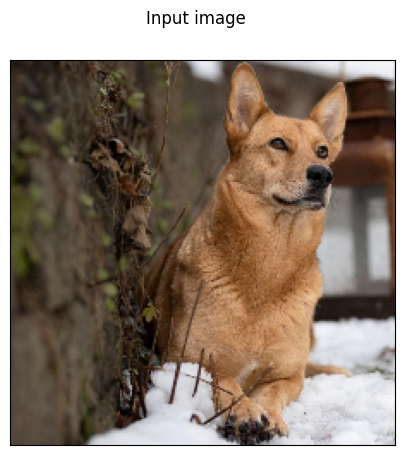

In [92]:
# load image
image = cv2.imread('image_dog.jpg')

# preprocess image
image = image[:, :image.shape[0]]
image = cv2.resize(image, (224, 224))
vis = Visualizer(num_rows=1, num_cols=1, figsize=(5,5), axis_off=True, title='Input image')
vis.add_image_subplot(0, 0, image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image / 255.0
image = image - np.array([0.485, 0.456, 0.406])
image = image / np.array([0.229, 0.224, 0.225])
image = image.transpose(2, 0, 1)
image = np.expand_dims(image, axis=0)
image = torch.from_numpy(image).float()


model = torch.hub.load('pytorch/vision', 'resnet50', weights=torchvision.models.resnet.ResNet50_Weights.DEFAULT)
class_names = torchvision.models.resnet.ResNet18_Weights.DEFAULT.meta["categories"]

# pass image through model
output = model(image)
pred = output.argmax()
print(f'Predicted class: {class_names[pred]}')

top_class = 637 # This is the class for 'mailbox'
num_iterations = 50
input = image  # TODO: initialise with image
input = torch.nn.Parameter(input, requires_grad=True)
optimizer = torch.optim.Adam([input], lr=0.1)

for i in tqdm(range(num_iterations)):
    prediction = model(input)
    loss = torch.nn.functional.cross_entropy(prediction,torch.tensor([637],dtype=torch.long))  # TODO: find a loss function that maximises the class score
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



In [71]:
print(torch.min(image))

tensor(-3.7879)


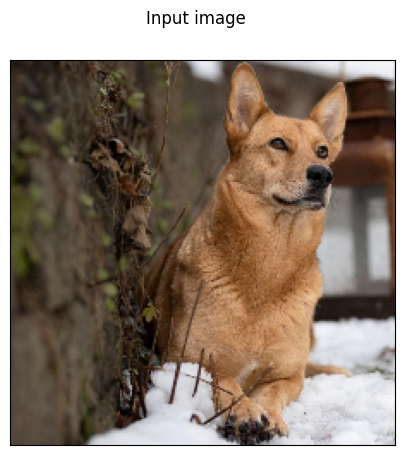

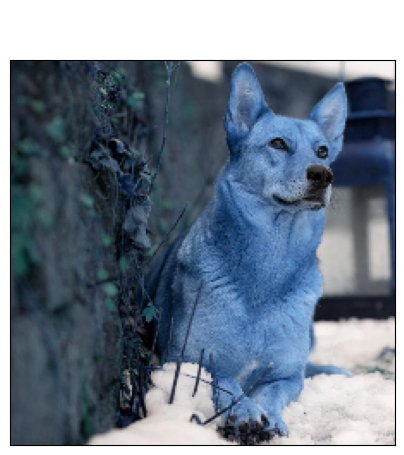

In [93]:
image = cv2.imread('image_dog.jpg')

# preprocess image
image = image[:, :image.shape[0]]
image = cv2.resize(image, (224, 224))
vis = Visualizer(num_rows=1, num_cols=1, figsize=(5,5), axis_off=True, title='Input image')
vis.add_image_subplot(0, 0, image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
save=image
image = image / 255.0
image = image - np.array([0.485, 0.456, 0.406])
image = image / np.array([0.229, 0.224, 0.225])
image = image.transpose(2, 0, 1)
image = np.expand_dims(image, axis=0)
image = torch.from_numpy(image).float()

vis = Visualizer(num_rows=1, num_cols=1, figsize=(5,5), axis_off=True, title=f' ')
denormalised=de_normalise_image(image)
#print(save==denormalised)
vis.add_image_subplot(0, 0, denormalised.astype(int))

In [89]:
print(np.min(save))
print(np.min(denormalised))

0
-5.836486810517627e-06


torch.Size([1, 3, 224, 224])
Predicted class of adversarial example: mailbox


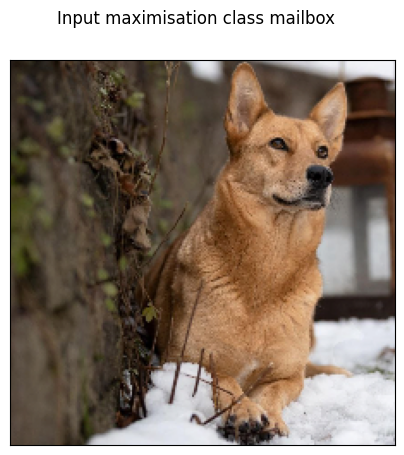

In [97]:
def de_normalise_image(x):
    x=x.view(3,224,224)
    x=x.permute(1,2,0)
    x=x.numpy()
    x=x*np.array([0.229, 0.224, 0.225])
    x=x+np.array([0.485, 0.456, 0.406])
    x=x*255.0
    x=x.astype(np.uint8)
    x = cv2.cvtColor(x, cv2.COLOR_RGB2BGR)
    return x

vis = Visualizer(num_rows=1, num_cols=1, figsize=(5,5), axis_off=True, title=f'Input maximisation class {class_names[top_class]}')
denormalised_image=de_normalise_image(image)
vis.add_image_subplot(0, 0, de_normalise_image(image))

# pass image through model
output = model(input)
# get class index
pred = output.argmax()
print(f'Predicted class of adversarial example: {class_names[pred]}')

Visualise the difference image between the original and the adversarial example.
* Do the same for different classes.
* Modify the code so that the loop ends as soon as the target class is higher than all others. Are some classes "easier" than others?

## Optional Tasks
* Save and load an adversarial example to and from a jpg file. Does it still work? Why? How could you make it more robust?
* Universal perturbations: another curious finding is that there are universal perturbations. A UP is a noise pattern $\epsilon$ that, if added to _any_ image, causes a misclassification as the target class. Try to find a universal perturbation for one of your CIFAR10 CNNs from the first problem of this sheet. You can do this by running the learning of the perturbation over batches of the training set. For each image in the batch, you will need to add your universal perturbation. The only thing that is learned in this training loop is the pattern (the model stays fixed). Learn your universal perturbation on the training set and show some examples on the test set. How do they compare to adversarial examples?
